In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, r2_score

from sklearn import linear_model
from sklearn.neural_network import MLPClassifier

In [3]:
from chiffresManuscrits_apprentissage import plot_confusion_matrix
from chiffresManuscrits_apprentissage import get_accuracy

# Utilisation d’un PMC pour la classification de Chiffres Manuscrits
# Notion d'optimisation d'une architecture

## Jeux d'apprentissage

### Choix de l'entrée du classifieur
Ici, on choisit le codage binaire (i.e. représenté par des -1 et des 1) que l'on va mettre en entrée du perceptron multicouches. Chaque représentation du chiffre manuscrit correspond à un vecteur.  
On peut utiliser le codage brut chiffre manuscrit avec son codage d'un 1 pour les pixels sur lesquels le stylo est passé et -1 là où il n'est pas passé. (L'imagette est mise sous forme de vecteur en mettant les lignes les unes à la suite des autres.)  

In [55]:
x = np.loadtxt("x.txt")

On peut aussi l'une des multiples variantes de codages associées à la représentation du nombre proposées.

In [56]:
hx = np.loadtxt("hx.txt")
hx_hy = np.loadtxt("hx_hy.txt")
pb_ph = np.loadtxt("pb_ph.txt")
pg_pd = np.loadtxt("pg_pd.txt")

On peut aussi choisir d'utiliser une combinaison.

In [57]:
hx_hy_pb_ph = np.loadtxt("hx_hy_pb_ph.txt")
hx_hy_pg_pd = np.loadtxt("hx_hy_pg_pd.txt")

Parmi, toutes ces possibilités, on en garde une comme entrée du réseau `X`.  
Pour la suite, on supprime les autres.

In [58]:
X = x.T
#del x, hx, hx_hy, pb_ph, pg_pd, hx_hy_pb_ph, hx_hy_pg_pd

Pour ce qui est de la sortie, il s'agit d'un vecteur codant la classe  associée au chiffre manuscrit.  
La sortie désirée (`t` pour target) est, comme les entrées, un vecteur binaire (i.e. représenté par des -1 et des 1) de 10 colonnes (une pour chaque classe). Tous les éléments sont à -1 à l'exception de l'élément dont l'indice correspondant à la classe.   
Ainsi une représentation manuscrite des nombres 0, 3 et 9 auront tous leurs éléments à -1 à l'exception de leur, respectivement, premier, quatrième et dixième élément qui lui vaudra 1.  

In [59]:
t = np.loadtxt("t.txt").T
t_label_num = np.where(t==1)[1]
classes = np.unique(t_label_num)
class_label = ['zero','un','deux','trois','quatre','cinq','six','sept','huit','neuf']
t_label_str = [ class_label[i] for i in t_label_num]

**Pour la suite on à décider de remplacer les -1 par des 0.**  
Ainsi pour chaque chiffre on a neuf 0 et un 1. 
On a donc les probabilités d'appartenance aux classes de chiffres comme sorties désirées.  
La sortie fournit par le PMC correspondra ainsi à la probabilité estimée par le réseau.  
(Attention, un PMC n'a pas par défaut de contrainte pour respecter les axiomes des probabilités.  
Il pourra fournir des sorties inférieures à 0, supérieures à 1 ainsi qu'une somme des dix sorties elle aussi inférieure à 0 ou supérieure à 1.)

In [9]:
t[np.where(t==-1)] = 0

Il nous reste à réaliser nos ensembles d'apprentissage.  
On a $48 \times 10$ chiffres manuscrits qui correspondent à $48$ séries de $10$ chiffres ordonnés allant de $0$ à $9$.  
On va grossièrement prendre les premières séries pour l'apprentissage et les dernières pour le test.

### Réalisation des ensemble d'appre,tissage et de test
Pour l'apprentissage on ajoute un ensemble (`X_appVal`,`t_appVal`) contenant les données qui serviront pour constituer les ensembles d'apprentissage et de validation utilisées par le pmc pour apprendre.    
(Regarder pour avoir des valeurs de `n_train` et de  `validation_fraction` appropriées.)    
L'ensemble (`X_test`,`t_test`) correspondra à l'enseble de test. 

In [10]:
n_train = 28*10
# rescale the data, use the traditional train/test split
X_appVal, X_test = X[:n_train,:], X[n_train:,:]
t_appVal, t_test = t[:n_train,:], t[n_train:,:]
t_label_appVal, t_label_test = t_label_num[:n_train], t_label_num[n_train:]

In [11]:
mlp = MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=5000,
                    alpha=1e-4,
                    validation_fraction=.7,
                    verbose=5000,
                    #solver='sgd', 
                    tol=1e-6, 
                    solver='lbfgs', learning_rate = 'adaptive',
                    random_state=1)
mlp = MLPClassifier(hidden_layer_sizes=(50,), max_iter=10, alpha=1e-4,
                    solver='sgd', verbose=10, tol=1e-4, random_state=1,
                   learning_rate_init=.1)

mlp.fit(X_appVal, t_appVal)
print("Training set score: %f" % mlp.score(X_appVal, t_appVal))
print("Test set score: %f" % mlp.score(X_test, t_test))

Iteration 1, loss = 8.96327829
Iteration 2, loss = 4.05367163
Iteration 3, loss = 3.45453726
Iteration 4, loss = 2.64099740
Iteration 5, loss = 2.30812487
Iteration 6, loss = 2.10575991
Iteration 7, loss = 1.73474438
Iteration 8, loss = 1.67130920
Iteration 9, loss = 0.98273590
Iteration 10, loss = 0.81468315
Training set score: 0.767857
Test set score: 0.615000


/home/moumene/.conda/envs/ds/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


## Apprentissage 

Dans cette partie, dans un cadre contraint, on va chercher à déterminer une architecture optimale.
Dans la suite, on s'intéressara à trois types d’architectures.
Pour cette architecture optimale, avec un jeu de poids associés, on calculera les performances en apprentissage validation et test.


### Optimisation de la première architecure 

Ici, on s'intéresse à un réseau linéaire entièrement connecté sans couche cachée.
On effectue donc une régression multilinéaire.    
[Ordinary least squares Linear Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression)

In [12]:

ols = linear_model.Ridge()

#scaler = preprocessing.StandardScaler().fit(X_appVal)
#scaler = preprocessing.MinMaxScaler().fit(X_appVal)
#scaler = preprocessing.Normalizer().fit(X_appVal)
# X_scaled = scaler.transform(X_appVal)
ols.fit(X_appVal, t_appVal)

Ridge()

**On apprend des valeurs à 1 ou à 0 pour chacune des dix classes.**    
Ainsi, si les données sont bien apprises les valeurs estimées en sortie devraient être proches de 0 ou de 1.

In [13]:
t_appVal_prediction = ols.predict(X_appVal)
t_appVal_prediction.shape

(280, 10)

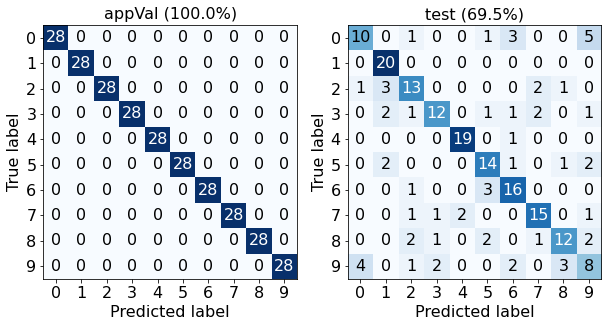

In [14]:
t_appVal_prediction = ols.predict(X_appVal)
t_label_appVal_prediction = np.argmax(t_appVal_prediction, axis=1)

t_test_prediction = ols.predict(X_test)
t_label_test_prediction = np.argmax(t_test_prediction, axis=1)
t_test_prediction.shape, t_label_test.shape, t_label_test_prediction.shape

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
titre = "appVal ({:.1f}%)".format(get_accuracy(t_label_appVal_prediction,
                                                       t_label_appVal))
plot_confusion_matrix(t_label_appVal,t_label_appVal_prediction,classes,title=titre)
plt.subplot(1,2,2)
titre = "test ({:.1f}%)".format(get_accuracy(t_label_test_prediction,
                                                       t_label_test))
plot_confusion_matrix(t_label_test,t_label_test_prediction,classes,title=titre)

In [15]:
from sklearn.metrics import classification_report

print(classification_report(t_label_test, t_label_test_prediction))

              precision    recall  f1-score   support

           0       0.67      0.50      0.57        20
           1       0.74      1.00      0.85        20
           2       0.65      0.65      0.65        20
           3       0.75      0.60      0.67        20
           4       0.90      0.95      0.93        20
           5       0.67      0.70      0.68        20
           6       0.67      0.80      0.73        20
           7       0.75      0.75      0.75        20
           8       0.71      0.60      0.65        20
           9       0.42      0.40      0.41        20

    accuracy                           0.69       200
   macro avg       0.69      0.70      0.69       200
weighted avg       0.69      0.69      0.69       200



In [16]:
print('Mean squared error (appVal)           : %.2f'
      % mean_squared_error(t_label_appVal, t_label_appVal_prediction))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination (appVal) : %.2f'
      % r2_score(t_label_appVal, t_label_appVal_prediction))
print()
print('Mean squared error (test)             : %.2f'
      % mean_squared_error(t_label_test, t_label_test_prediction))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination (test)   : %.2f'
      % r2_score(t_label_test, t_label_test_prediction))


Mean squared error (appVal)           : 0.00
Coefficient of determination (appVal) : 1.00

Mean squared error (test)             : 7.34
Coefficient of determination (test)   : 0.11


### Optimisation de la seconde architecure 

Ici, on s'intéresse à un réseau Sigmoïdal entièrement connecté sans couche cachée.
On effectue donc une transformation non linéaire à la réponse fournie par une régression multilinéaire.    
[Logistic Regression (aka logit, MaxEnt) classifier.](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression)    
(En regardant vous verrez que l'on peut peu-être faire mieux que ce qui est fait ici.)

In [17]:
X_appVal.shape, t_appVal.shape

((280, 256), (280, 10))

In [18]:
logitReg = linear_model.LogisticRegression(random_state=0,max_iter=1000,multi_class="multinomial",solver="lbfgs",penalty='l2')

#scaler = preprocessing.StandardScaler().fit(X_appVal)
#scaler = preprocessing.MinMaxScaler().fit(X_appVal)
#scaler = preprocessing.Normalizer().fit(X_appVal)
# X_scaled = scaler.transform(X_appVal)
logitReg.fit(X_appVal, t_label_appVal) 

LogisticRegression(max_iter=1000, multi_class='multinomial', random_state=0)

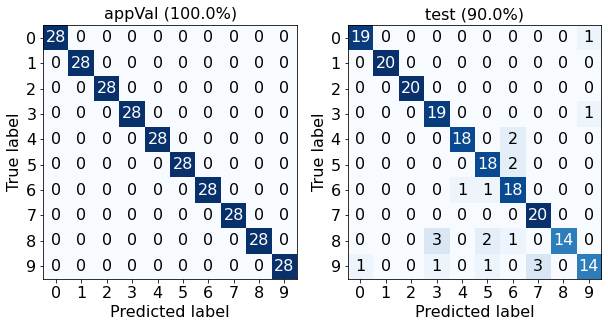

In [19]:
t_label_appVal_prediction = logitReg.predict(X_appVal)
t_label_test_prediction = logitReg.predict(X_test)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
titre = "appVal ({:.1f}%)".format(get_accuracy(t_label_appVal_prediction,
                                                       t_label_appVal))
plot_confusion_matrix(t_label_appVal,t_label_appVal_prediction,classes,title=titre)
plt.subplot(1,2,2)
titre = "test ({:.1f}%)".format(get_accuracy(t_label_test_prediction,
                                                       t_label_test))
plot_confusion_matrix(t_label_test,t_label_test_prediction,classes,title=titre)

In [20]:
print('Mean squared error (appVal)           : %.2f'
      % mean_squared_error(t_label_appVal, t_label_appVal_prediction))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination (appVal) : %.2f'
      % r2_score(t_label_appVal, t_label_appVal_prediction))
print()
print('Mean squared error (test)             : %.2f'
      % mean_squared_error(t_label_test, t_label_test_prediction))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination (test)   : %.2f'
      % r2_score(t_label_test, t_label_test_prediction))


Mean squared error (appVal)           : 0.00
Coefficient of determination (appVal) : 1.00

Mean squared error (test)             : 1.87
Coefficient of determination (test)   : 0.77


In [21]:
from sklearn.metrics import classification_report

print(classification_report(t_label_test, t_label_test_prediction))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95        20
           1       1.00      1.00      1.00        20
           2       1.00      1.00      1.00        20
           3       0.83      0.95      0.88        20
           4       0.95      0.90      0.92        20
           5       0.82      0.90      0.86        20
           6       0.78      0.90      0.84        20
           7       0.87      1.00      0.93        20
           8       1.00      0.70      0.82        20
           9       0.88      0.70      0.78        20

    accuracy                           0.90       200
   macro avg       0.91      0.90      0.90       200
weighted avg       0.91      0.90      0.90       200



### Optimisation de la troisième architecure 

Ici, le classifieur devient un réseau entièrement connecté à une couche caché.
Cela est éqiuvalent à utiliser une combinaison linéaires des réseaux sigmaodïdaux de la question précédente.    
[Multi-layer Perceptron classifier.](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)  
(En regardant vous verrez que l'on peut peu-être faire mieux que ce qui est fait ici.)

In [22]:
labels=[] 
for x in t:
    labels.append(np.where(x==1)[0][0])

In [23]:
n_train = 28*10
# rescale the data, use the traditional train/test split
X_appVal, X_test = X[:n_train,:], X[n_train:,:]
t_appVal, t_test = labels[:n_train], labels[n_train:]
t_label_appVal, t_label_test = t_label_num[:n_train], t_label_num[n_train:]

In [24]:
mlp = MLPClassifier(hidden_layer_sizes=(20), max_iter=4000,
                    alpha=1e-4,
                    activation='relu',
                    validation_fraction=.7,
                    #solver='sgd', 
                    tol=1e-6, 
                    solver='lbfgs', learning_rate = 'adaptive',
                    random_state=1)

mlp.fit(X_appVal, t_appVal)
print("Training set score: %f" % mlp.score(X_appVal, t_appVal))
print("Test set score: %f" % mlp.score(X_test, t_test))

Training set score: 1.000000
Test set score: 0.925000


In [25]:
t_appVal_prediction = mlp.predict(X_appVal)
t_appVal_prediction

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1,
       2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3,
       4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5,
       6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7,
       8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9,
       0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1,
       2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3,
       4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5,
       6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7,
       8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9,
       0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1,
       2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3,
       4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [27]:
#mlp.predict_proba(X_appVal).sum(axis=1)

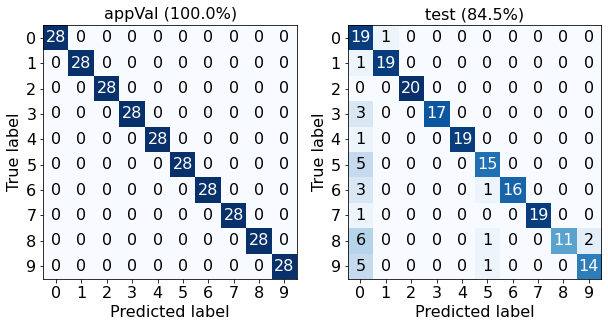

In [311]:
t_appVal_prediction = mlp.predict(X_appVal)
t_label_appVal_prediction = np.argmax(t_appVal_prediction, axis=1)

t_test_prediction = mlp.predict(X_test)
t_label_test_prediction = np.argmax(t_test_prediction, axis=1)
t_test_prediction.shape, t_label_test.shape, t_label_test_prediction.shape

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
titre = "appVal ({:.1f}%)".format(get_accuracy(t_label_appVal_prediction,
                                                       t_label_appVal))
plot_confusion_matrix(t_label_appVal,t_label_appVal_prediction,classes,title=titre)
plt.subplot(1,2,2)
titre = "test ({:.1f}%)".format(get_accuracy(t_label_test_prediction,
                                                       t_label_test))
plot_confusion_matrix(t_label_test,t_label_test_prediction,classes,title=titre)

In [42]:
t_appVal_prediction = mlp.predict(X_appVal)
t_label_appVal_prediction = t_appVal_prediction

t_test_prediction = mlp.predict(X_test)
t_label_test_prediction = t_test_prediction
t_test_prediction.shape, t_label_test.shape, t_label_test_prediction.shape

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
titre = "appVal ({:.1f}%)".format(get_accuracy(t_label_appVal_prediction,
                                                       t_label_appVal))
plot_confusion_matrix(t_label_appVal,t_label_appVal_prediction,classes,title=titre)
plt.subplot(1,2,2)
titre = "test ({:.1f}%)".format(get_accuracy(t_label_test_prediction,
                                                       t_label_test))
plot_confusion_matrix(t_label_test,t_label_test_prediction,classes,title=titre)

NotFittedError: This MLPClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [430]:
t_appVal

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [34]:
from sklearn.model_selection import GridSearchCV
parameters = {'hidden_layer_sizes':np.arange(9,21),'early_stopping':[True],'alpha':[1e-2,1e-3,1e-4],'solver':['adam'],'max_iter':[5000],'activation':['relu','logistic'],'learning_rate' : ['adaptive']}
mlp = MLPClassifier()
clf = GridSearchCV(mlp, parameters,verbose=1,cv=5,n_jobs=8)
clf.fit(X_appVal, t_appVal)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  52 tasks      | elapsed:    1.7s
[Parallel(n_jobs=8)]: Done 360 out of 360 | elapsed:    8.9s finished


GridSearchCV(cv=5, estimator=MLPClassifier(), n_jobs=8,
             param_grid={'activation': ['relu', 'logistic'],
                         'alpha': [0.01, 0.001, 0.0001],
                         'early_stopping': [True],
                         'hidden_layer_sizes': array([ 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]),
                         'learning_rate': ['adaptive'], 'max_iter': [5000],
                         'solver': ['adam']},
             verbose=1)

In [36]:
clf.predict(X_test)

array([0, 1, 2, 3, 4, 5, 6, 3, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 3, 5, 9, 1,
       2, 3, 4, 5, 6, 7, 8, 9, 0, 6, 2, 3, 4, 5, 6, 7, 6, 9, 0, 1, 2, 3,
       4, 5, 2, 7, 3, 0, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 8, 4, 5,
       6, 7, 8, 0, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7,
       5, 9, 0, 1, 2, 3, 5, 9, 6, 7, 8, 9, 0, 1, 2, 3, 1, 1, 0, 7, 8, 9,
       0, 1, 9, 3, 6, 5, 6, 2, 8, 9, 0, 1, 2, 3, 4, 6, 6, 7, 9, 9, 0, 1,
       2, 3, 4, 5, 5, 7, 8, 5, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 0, 7,
       4, 5, 6, 7, 8, 5, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5,
       4, 9, 8, 9, 0, 1, 2, 3, 4, 6, 5, 8, 2, 9, 0, 1, 2, 5, 4, 5, 6, 7,
       8, 0])

In [37]:
t_label_test_prediction = clf.best_estimator_.predict(X_test)

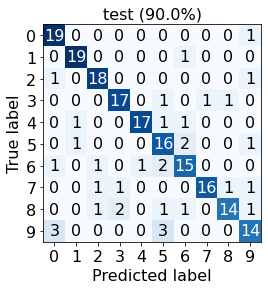

In [38]:
plot_confusion_matrix(t_label_test,t_label_test_prediction,classes,title=titre)

In [70]:
encodage = [hx,hx_hy,pb_ph,pg_pd,hx_hy_pb_ph,hx_hy_pg_pd]
name_encodage = ['no encoding','hx','hx_hy','pb_ph','pg_pd','hx_hy_pb_ph','hx_hy_pg_pd']

In [107]:
from itertools import product
les_classifieurs  = list()
testScore = list()
validScore = list()
lesScoresCrossVal= list()
for data in encodage:
    X_appVal, X_test = data.T[:384,:], data.T[384:,:]
    t_appVal = labels[:384]
    t_test = labels[384:]

    parameters = {'hidden_layer_sizes':np.arange(9,21),'early_stopping':[True],'alpha':[1e-2,1e-3,1e-4],'solver':['lbfgs'],'max_iter':[5000],'activation':['relu','logistic'],'learning_rate' : ['adaptive']}
    mlp = MLPClassifier()
    clf = GridSearchCV(mlp, parameters,verbose=1,cv=5,n_jobs=8)
    clf.fit(X_appVal, t_appVal)
    les_classifieurs.append(clf)
    validScore.append(accuracy_score(clf.predict(X_appVal),t_appVal))
    testScore.append(accuracy_score(clf.predict(X_test),t_test))
    #score_encodage.append(clf)
    #score=clf.(KNN(n_neighbors,weights=weights,metric=dist,n_jobs=-1),X_appVal,t_appVal,cv=5)
    #lesScoresCrossVal.append(score.mean())
    #score_encodage.append(lesScoresCrossVal)
    #print(score_encodage)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   15.6s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  1.9min
[Parallel(n_jobs=8)]: Done 360 out of 360 | elapsed:  9.3min finished
/home/moumene/.conda/envs/ds/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   13.9s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   38.3s
[Parallel(n_jobs=8)]: Done 360 out of 360 | elapsed:  1.0min finished


Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  1.3min
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  4.2min
[Parallel(n_jobs=8)]: Done 360 out of 360 | elapsed:  9.0min finished


Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  52 tasks      | elapsed:    2.3s
[Parallel(n_jobs=8)]: Done 360 out of 360 | elapsed:   10.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    9.9s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   43.5s
[Parallel(n_jobs=8)]: Done 360 out of 360 | elapsed:  1.3min finished


Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  52 tasks      | elapsed:    2.8s
[Parallel(n_jobs=8)]: Done 360 out of 360 | elapsed:   15.0s finished


In [108]:
import plotly.graph_objects as go

fig = go.Figure([go.Bar(x= name_encodage+[str(c.best_params_) for i,c in enumerate(les_classifieurs)], y=validScore),go.Bar(x= name_encodage+[str(c.best_params_) for i,c in enumerate(les_classifieurs)], y=testScore)])

fig.show()

{'activation': 'relu',
 'alpha': 0.0001,
 'early_stopping': True,
 'hidden_layer_sizes': 19,
 'learning_rate': 'adaptive',
 'max_iter': 5000,
 'solver': 'adam'}

In [444]:
mlp = MLPClassifier(hidden_layer_sizes=(20), max_iter=4000,
                    alpha=1e-4,
                    activation='relu',
                    validation_fraction=.7,
                    #solver='sgd', 
                    tol=1e-6, 
                    solver='lbfdgs', learning_rate = 'adaptive',
                    random_state=1)
mlp.fit(X_appVal,t_appVal)

ValueError: The solver lbfdgs is not supported.  Expected one of: sgd, adam, lbfgs